## Import required packages

In [19]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import swat   # SAS Viya Python interface

%matplotlib inline

## Download and Prep NASA's Turbofan Engine Degradation Simulation (PHM08 Challenge) Data Set

In [2]:
DATA_URL = 'https://ti.arc.nasa.gov/m/project/prognostic-repository/Challenge_Data.zip'
DATA_DIR = '.'

train_tsv = os.path.join(DATA_DIR, 'train.txt')
test_tsv = os.path.join(DATA_DIR, 'test.txt')

if not os.path.isfile(train_tsv) or not os.path.isfile(test_tsv):
    import zipfile
    from six.moves import urllib
    try:
        filename, headers = urllib.request.urlretrieve(DATA_URL)
        with zipfile.ZipFile(filename, 'r') as data_zip:
            data_zip.extract('train.txt', DATA_DIR)
            data_zip.extract('test.txt', DATA_DIR)
    finally:
        urllib.request.urlcleanup()

Read training data into a DataFrame.

In [3]:
# Create list of x1-x24
x = ['x%s' % i for i in range(1, 25)]

In [4]:
df = pd.read_table(train_tsv, delim_whitespace=True, names=['engine', 'cycle'] + x)
df.head()

,engine,cycle,x1,x2,x3,x4,x5,x6,x7,x8,...,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


Create training data with 30 random engines

In [5]:
train = df[df['engine'].isin([7, 28, 32, 38, 40, 51, 65, 84, 90, 95, 99, 107, 
                              120, 124, 135, 137, 138, 148, 151, 160, 166, 178,
                              182, 188, 197, 199, 200, 207, 210, 211])]

# Keep first 50 observations per engine to train SVDD 
train = train[train['cycle'] <= 50]
train['index'] = train.index

train.tail()

,engine,cycle,x1,x2,x3,x4,x5,x6,x7,x8,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,index
44296,211,46,0.0019,0.0015,100.0,518.67,642.32,1585.44,1403.71,14.62,...,2388.05,8136.64,8.4008,0.03,392,2388,100.00,38.94,23.4167,44296
44297,211,47,25.0045,0.6204,80.0,462.54,536.09,1261.04,1043.58,7.05,...,2028.23,7877.28,10.8351,0.02,306,1915,84.93,14.33,8.5657,44297
44298,211,48,25.0009,0.6200,80.0,462.54,536.70,1258.17,1045.69,7.05,...,2028.16,7868.87,10.8982,0.02,307,1915,84.93,14.15,8.5617,44298
44299,211,49,34.9992,0.8400,60.0,449.44,555.55,1357.05,1124.54,5.48,...,2387.98,8060.58,9.3039,0.02,333,2223,100.00,15.05,9.0326,44299
44300,211,50,34.9985,0.8401,60.0,449.44,555.79,1361.79,1115.64,5.48,...,2388.03,8065.22,9.2908,0.02,334,2223,100.00,14.88,9.0062,44300


Read test data into a DataFrame.

In [6]:
df = pd.read_table('test.txt', delim_whitespace=True, names=['engine', 'cycle'] + x)

# create a scoring data set with 9 random engines from the test data set
df['index'] = df.index
score = df[df['engine'].isin([1, 8, 22, 53, 63, 86, 102, 158, 170, 202])]
score.tail()

,engine,cycle,x1,x2,x3,x4,x5,x6,x7,x8,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,index
27762,202,220,25.0016,0.6200,80.0,462.54,536.90,1269.39,1060.73,7.05,...,2028.26,7871.43,10.9634,0.02,310,1915,84.93,14.24,8.4615,27762
27763,202,221,0.0028,0.0000,100.0,518.67,643.27,1598.17,1421.01,14.62,...,2388.21,8138.45,8.4976,0.03,395,2388,100.00,38.68,23.1797,27763
27764,202,222,34.9982,0.8400,60.0,449.44,555.96,1377.66,1141.88,5.48,...,2388.13,8069.36,9.3483,0.02,335,2223,100.00,14.69,8.9512,27764
27765,202,223,25.0020,0.6208,80.0,462.54,537.21,1267.70,1063.08,7.05,...,2028.27,7878.83,11.0023,0.02,309,1915,84.93,14.22,8.4076,27765
27766,202,224,24.9998,0.6200,80.0,462.54,537.08,1270.70,1064.61,7.05,...,2028.28,7884.13,10.9798,0.02,309,1915,84.93,14.13,8.4066,27766


### Connect to SAS Viya CAS Engine

In [8]:
s = swat.CAS('localhost', 5570)

### Load  pandas DataFrames into CAS

In [9]:
train_tbl = s.upload_frame(train, casout=dict(name='train', replace=True))
score_tbl = s.upload_frame(score, casout=dict(name='score', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSER(kesmit).
NOTE: The table TRAIN has been created in caslib CASUSER(kesmit) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table SCORE in caslib CASUSER(kesmit).
NOTE: The table SCORE has been created in caslib CASUSER(kesmit) from binary data uploaded to Cloud Analytic Services.


Check details of loaded tables.

In [10]:
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,ModTime,AccessTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,TRAIN,1500,27,0,utf-8,04Oct2017:18:54:20,04Oct2017:18:54:20,04Oct2017:18:54:20,UTF8,1.822762e+09,1.822762e+09,1.822762e+09,0,0,0,,,0,kesmit,
1,SCORE,1502,27,0,utf-8,04Oct2017:18:54:21,04Oct2017:18:54:21,04Oct2017:18:54:21,UTF8,1.822762e+09,1.822762e+09,1.822762e+09,0,0,0,,,0,kesmit,


### Import SVDD action set

In [11]:
s.loadactionset('svdd')

NOTE: Added action set 'svdd'.


[actionset]

 u'svdd'

+ Elapsed: 0.00209s, user: 0.002s, mem: 0.237mb

### Create SVDD model for training data

In [12]:
# Run svdd.svddTrain action set on training data
ysvdd_state = s.CASTable('ysvddstate', replace=True)
state_s = s.CASTable('state_s', replace=True)

train_tbl.svdd.svddtrain(gauss=11,
                         solver='actset',
                         inputs=x,
                         savestate=ysvdd_state,
                         output=dict(casout=state_s),
                         id='index')

NOTE: Beginning data reading...
NOTE: Data reading complete.
NOTE: Beginning SVDD optimization...
NOTE: SVDD optimization complete.
NOTE: Output generation complete.
NOTE: Beginning of support vector table generation...
NOTE: Support vector table generation complete.
NOTE: Beginning save state generation...
NOTE: Wrote 37669 bytes to the savestate file ysvddstate.
NOTE: Save state generation complete.


[ModelInfo]

 Model Information
 
        RowId                   Description        Value     nValue
 0  OPTMETHOD           Optimization Method   Active set        NaN
 1    KERTYPE                   Kernel Type          RBF        NaN
 2         BW          RBF Kernel Bandwidth           11  11.000000
 3   RELSCALE      Bandwidth Relative Scale  0.089542561   0.089543
 4       FRAC     Expected Outlier Fraction         1E-6   0.000001
 5     OPTTOL        Optimization Tolerance       0.0001   0.000100
 6   NINTVARS  Number of Interval Variables           24  24.000000
 7   NNOMVARS   Number of Nominal Variables            0   0.000000

[Nobs]

 Number of Observations
 
                           Type       N
 0  Number of Observations Read  1500.0
 1  Number of Observations Used  1500.0

[OptSummary]

 Optimization Summary
 
        RowId           Description         Value    nValue
 0     NITERS  Number of Iterations             1  1.000000
 1        OBJ       Objective Value  0.0301437585  0.030144
 2      INFEA         Infeasibility  0.0000494674  0.000049
 3  OPTSTATUS   Optimization Status       Optimal       NaN
 4      DEGEN            Degenerate         False  0.000000

[TrainingResults]

 Training Results
 
     RowId                            Description       Value
 0     NSV              Number of Support Vectors  135.000000
 1    NSVB  Number of Support Vectors on Boundary  135.000000
 2  NDROBS         Number of Dropped Observations    0.000000
 3  THRESH                    Threshold R^2 Value    0.969932
 4     C_R                   Constant (C_r) Value    0.030144
 5   RTIME                     Run Time (Seconds)    0.076728

[OutputCasTables]

             casLib     Name Label  Rows  Columns  \
 0  CASUSER(kesmit)  state_s         135       27   
 
                                           casTable  
 0  CASTable(u'state_s', caslib=u'CASUSER(kesmit)')  

+ Elapsed: 0.207s, user: 0.173s, sys: 0.091s, mem: 50.8mb

In [13]:
sv = state_s.to_frame()
sv

,index,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X17,X18,X19,X20,X21,X22,X23,X24,_SVDDALPHA_,_SVDDOUTLIER_
0,1285.0,42.0068,0.8413,40.0,445.00,549.78,1359.17,1113.20,3.91,5.71,...,8087.68,9.3337,0.02,330.0,2212.0,100.00,10.76,6.3550,0.006056,0.0
1,1294.0,25.0021,0.6213,80.0,462.54,536.55,1254.33,1037.37,7.05,9.03,...,7869.70,10.8674,0.02,306.0,1915.0,84.93,14.22,8.5386,0.002464,0.0
2,1299.0,42.0020,0.8400,40.0,445.00,549.11,1341.54,1114.18,3.91,5.72,...,8089.02,9.3296,0.02,331.0,2212.0,100.00,10.60,6.3265,0.011382,0.0
3,1312.0,35.0037,0.8400,60.0,449.44,555.87,1356.61,1114.82,5.48,8.00,...,8066.95,9.3072,0.02,333.0,2223.0,100.00,14.80,8.9329,0.009289,0.0
4,1317.0,10.0002,0.2505,20.0,489.05,604.16,1495.14,1302.19,10.52,15.49,...,8132.86,8.6005,0.03,370.0,2319.0,100.00,28.68,17.1952,0.000666,0.0
5,5518.0,10.0047,0.2507,20.0,489.05,604.81,1503.70,1320.02,10.52,15.49,...,8130.53,8.6714,0.03,370.0,2319.0,100.00,28.67,17.2177,0.011125,0.0
6,5524.0,10.0068,0.2500,20.0,489.05,604.42,1503.76,1323.48,10.52,15.49,...,8126.49,8.6490,0.03,368.0,2319.0,100.00,28.44,17.1407,0.012131,0.0
7,5527.0,0.0027,0.0007,100.0,518.67,642.91,1585.05,1413.34,14.62,21.61,...,8117.66,8.4237,0.03,395.0,2388.0,100.00,38.91,23.1822,0.001383,0.0
8,6544.0,35.0028,0.8412,60.0,449.44,555.61,1370.41,1132.09,5.48,8.00,...,8065.85,9.3431,0.02,333.0,2223.0,100.00,14.88,8.8200,0.002926,0.0
9,7799.0,0.0025,0.0013,100.0,518.67,642.68,1580.83,1405.11,14.62,21.61,...,8122.67,8.4418,0.03,393.0,2388.0,100.00,38.81,23.3484,0.004536,0.0


### Score SVDD astore against scoring data

In [14]:
# Load astore action set
s.loadactionset('astore')

NOTE: Added action set 'astore'.


[actionset]

 u'astore'

+ Elapsed: 0.0011s, user: 0.000999s, mem: 0.266mb

In [15]:
# Score resulting SVDD astore (ysvddstate) against the scoring data (score) and output results (svddscored)
svdd_scored = s.CASTable('svddscored', replace=True)
score_tbl.astore.score(rstore=ysvdd_state, out=svdd_scored)

,Task,Seconds,Percent
0,Loading the Store,0.000093,0.000349
1,Creating the State,0.037361,0.140184
2,Scoring,0.229059,0.859457
3,Total,0.266516,1.000000


In [16]:
# Create local dataframe of scored data to plot using Matplotlib
output = svdd_scored.to_frame()
output.head()

,index,_SVDDDISTANCE_,_SVDDSCORE_
0,0.0,0.953083,-1.0
1,1.0,1.008100,1.0
2,2.0,0.957298,-1.0
3,3.0,0.966277,-1.0
4,4.0,0.960607,-1.0


In [17]:
# Add SVDD scored values to original score DataFrame for plotting purposes
df = score.merge(output, how='left')
df.head()

,engine,cycle,x1,x2,x3,x4,x5,x6,x7,x8,...,x18,x19,x20,x21,x22,x23,x24,index,_SVDDDISTANCE_,_SVDDSCORE_
0,1,1,0.0016,0.0002,100.0,518.67,642.88,1587.21,1412.44,14.62,...,8.4363,0.03,393,2388,100.00,38.97,23.3029,0,0.953083,-1.0
1,1,2,24.9993,0.6215,80.0,462.54,536.45,1262.64,1055.44,7.05,...,10.8935,0.02,308,1915,84.93,14.29,8.6686,1,1.008100,1.0
2,1,3,0.0004,0.0000,100.0,518.67,642.65,1589.75,1409.54,14.62,...,8.4620,0.03,393,2388,100.00,38.91,23.2693,2,0.957298,-1.0
3,1,4,10.0034,0.2500,20.0,489.05,604.44,1499.93,1315.34,10.52,...,8.6815,0.03,369,2319,100.00,28.60,17.0930,3,0.966277,-1.0
4,1,5,0.0024,0.0011,100.0,518.67,642.74,1585.47,1408.12,14.62,...,8.4617,0.03,392,2388,100.00,38.82,23.3124,4,0.960607,-1.0


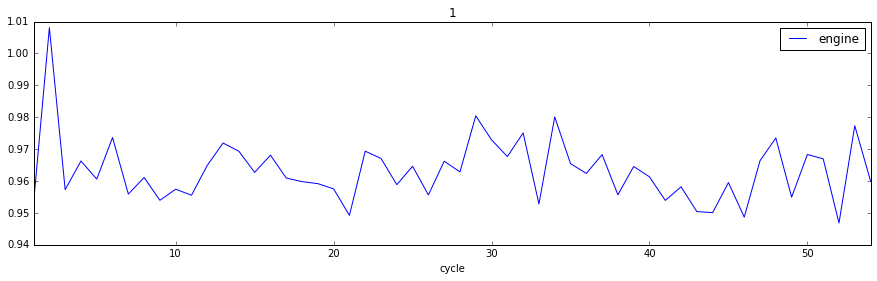

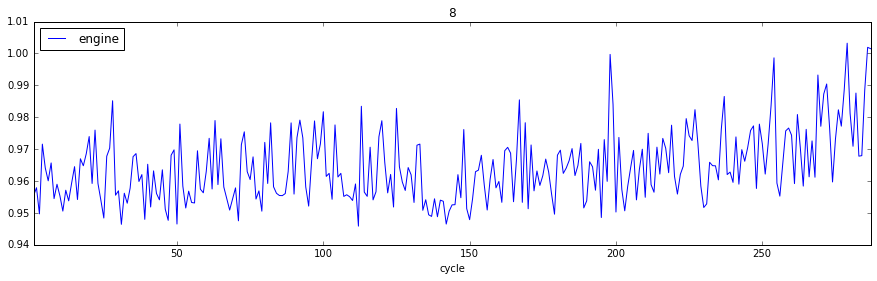

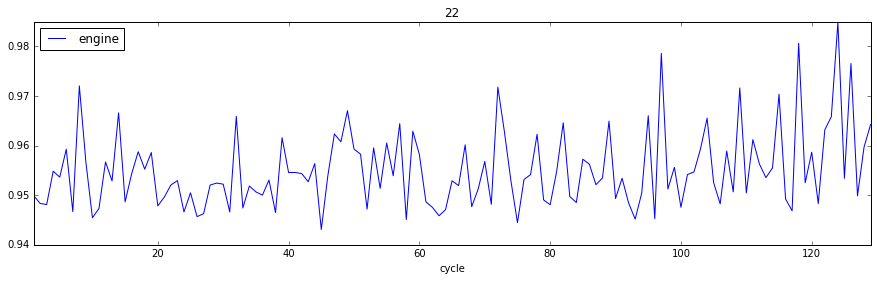

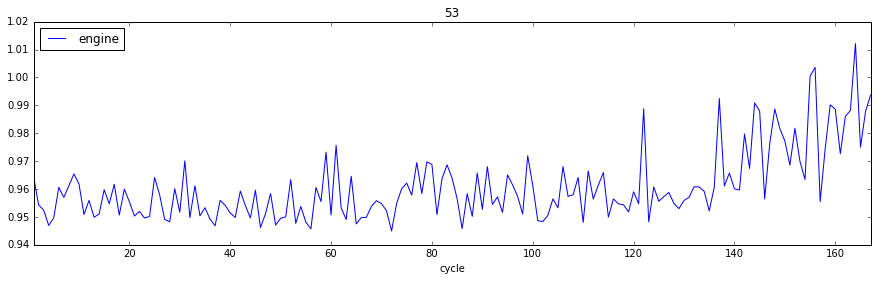

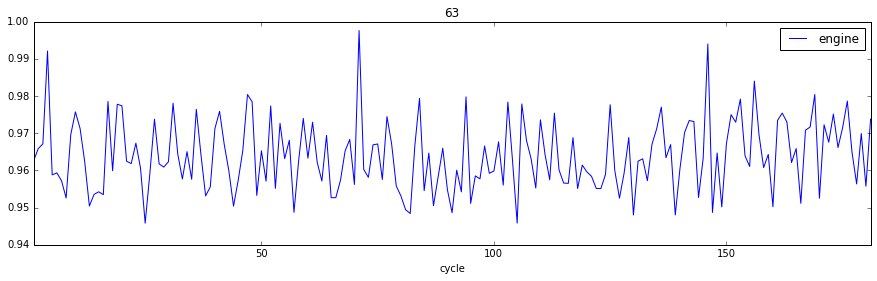

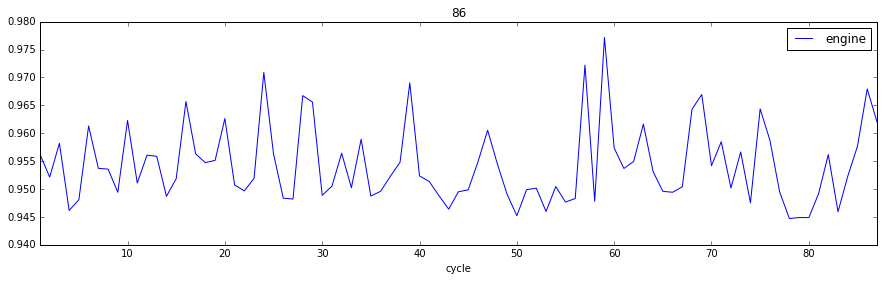

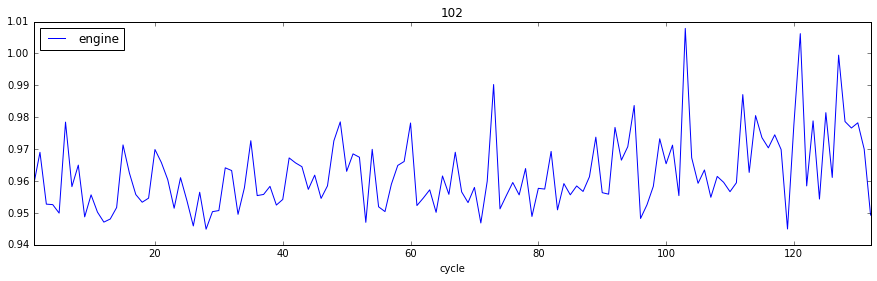

In [27]:
df = df.loc[df['engine'] < 150]
for index, group in df.groupby('engine'):
    group.plot(x='cycle', y='_SVDDDISTANCE_', title=index, label='engine', figsize=(15, 4))

plt.show()

### Save SVDD astore for use in SAS Event Stream Processing

In [22]:
# Download SVDD astore for use in SAS Event Stream Processing (ESP)
results = s.astore.download(rstore=ysvdd_state)

In [23]:
# Check details of loaded data
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,ModTime,AccessTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,TRAIN,1500,27,0,utf-8,04Oct2017:18:54:20,04Oct2017:18:54:20,04Oct2017:18:54:26,UTF8,1.822762e+09,1.822762e+09,1.822762e+09,0,0,0,,,0,kesmit,
1,SCORE,1502,27,0,utf-8,04Oct2017:18:54:21,04Oct2017:18:54:21,04Oct2017:18:54:30,UTF8,1.822762e+09,1.822762e+09,1.822762e+09,0,0,0,,,0,kesmit,
2,STATE_S,135,27,0,utf-8,04Oct2017:18:54:27,04Oct2017:18:54:27,04Oct2017:18:54:28,UTF8,1.822762e+09,1.822762e+09,1.822762e+09,0,0,0,,,0,kesmit,
3,YSVDDSTATE,1,2,0,utf-8,04Oct2017:18:54:27,04Oct2017:18:54:27,04Oct2017:18:56:37,UTF8,1.822762e+09,1.822762e+09,1.822763e+09,0,0,0,,,0,kesmit,
4,SVDDSCORED,1502,3,0,utf-8,04Oct2017:18:54:30,04Oct2017:18:54:30,04Oct2017:18:54:32,UTF8,1.822762e+09,1.822762e+09,1.822762e+09,0,0,0,,,0,kesmit,


### See ESP_Turbofan_Degradation.mp4 video showcasing how SVDD astore scores new observations in SAS ESP to detect asset degradation

<video width="980" height="600" controls source src="ESP_Turbofan_Degradation.mp4" />